# Classification des Qualités de Vins

Ce notebook présente une analyse complète de classification des qualités de Vins en utilisant différents modèles de machine learning(XGBoost, Kernel SVM).

## Table des Matières
1. Configuration et Chargement des Données
2. Préparation des Données
3. Modélisation et Évaluation
4. Optimisation des Modèles
5. Analyse des Résultats
6. Conclusions

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, learning_curve, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report


import joblib
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

In [27]:
data = pd.read_csv('juice_data.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_category
0,7.0,0.27,0.36,19.85,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1,6.3,0.30,0.34,1.60,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
2,8.1,0.28,0.40,6.90,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1
3,7.2,0.23,0.32,8.50,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,6.2,0.32,0.16,7.00,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6,1


In [28]:
data.shape

(3961, 13)

In [29]:
X = data.drop(['quality', 'quality_category'], axis=1)
y = data['quality_category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=y
)

print(f"Taille train: {X_train.shape}, taille test: {X_test.shape}")


Taille train: (3168, 11), taille test: (793, 11)


In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")



Train set: (3168, 11)
Test set: (793, 11)


In [31]:
# 2. Fonction d'évaluation
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    metrics = {
        'Model': model_name,
        'Train_Accuracy': accuracy_score(y_train, y_train_pred),
        'Test_Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_test_pred, average='weighted', zero_division=0),
        'F1-Score': f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
    }
    return metrics


In [32]:
xgb_base = XGBClassifier(random_state=123, use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1)
svm_base = SVC(kernel='rbf', probability=False, random_state=123)

In [33]:
xgb_results = evaluate_model(
    xgb_base, X_train_scaled, y_train, X_test_scaled, y_test, "XGBoost (base)"
)
svm_results = evaluate_model(
    svm_base, X_train_scaled, y_train, X_test_scaled, y_test, "SVM RBF (base)"
)

results_df = pd.DataFrame([xgb_results, svm_results])
display(results_df)

,Model,Train_Accuracy,Test_Accuracy,Precision,Recall,F1-Score
0,XGBoost (base),0.998422,0.605296,0.606688,0.605296,0.603937
1,SVM RBF (base),0.656881,0.605296,0.624649,0.605296,0.595428


In [34]:
best_idx = results_df["F1-Score"].idxmax()
best_model_name_init = results_df.loc[best_idx, "Model"]
best_f1_init = results_df.loc[best_idx, "F1-Score"]

print(f"Meilleur modèle initial : {best_model_name_init} (F1 = {best_f1_init:.4f})")

Meilleur modèle initial : XGBoost (base) (F1 = 0.6039)


In [35]:
train_acc = results_df.loc[best_idx, "Train_Accuracy"]
test_acc = results_df.loc[best_idx, "Test_Accuracy"]
gap = train_acc - test_acc
print(f"Écart train-test : {gap:.4f}")
if gap > 0.05:
    print("⚠️  Risque de surapprentissage (overfitting)")
else:
    print("✅ Généralisation correcte")


Écart train-test : 0.3931
⚠️  Risque de surapprentissage (overfitting)


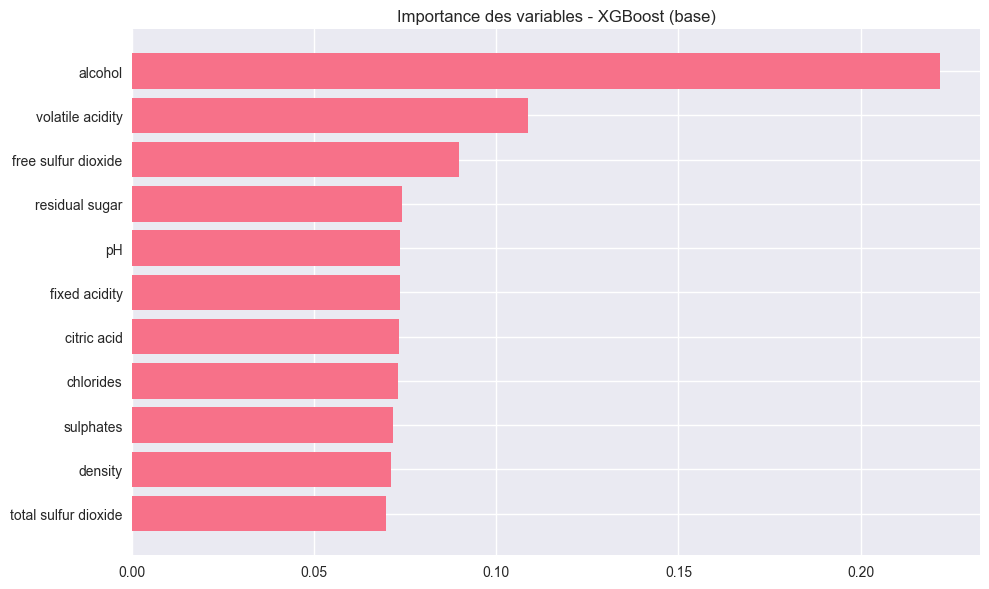


Top 5 variables (XGBoost base) :


,feature,importance
10,alcohol,0.221704
1,volatile acidity,0.108646
5,free sulfur dioxide,0.089805
3,residual sugar,0.074049
8,pH,0.073548


In [36]:
# 7. Interprétabilité : importance des features XGBoost
xgb_base.fit(X_train_scaled, y_train)

if hasattr(xgb_base, "feature_importances_"):
    feature_imp_xgb = pd.DataFrame({
        "feature": X.columns,
        "importance": xgb_base.feature_importances_
    }).sort_values("importance")

    plt.figure(figsize=(10, 6))
    plt.barh(feature_imp_xgb["feature"], feature_imp_xgb["importance"])
    plt.title("Importance des variables - XGBoost (base)")
    plt.tight_layout()
    plt.show()

    print("\nTop 5 variables (XGBoost base) :")
    display(feature_imp_xgb.tail(5).iloc[::-1])
else:
    print("XGBoost n'a pas d'attribut feature_importances_.")


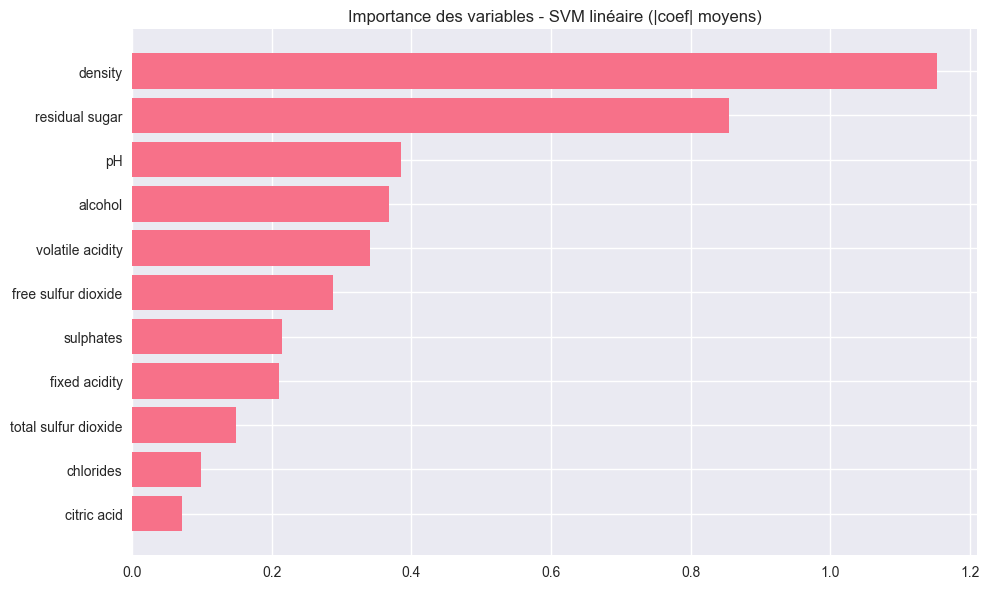


Top 5 variables (SVM linéaire) :


,feature,importance
7,density,1.152919
3,residual sugar,0.855066
8,pH,0.385335
10,alcohol,0.368034
1,volatile acidity,0.341159


In [37]:
# 8. Interprétabilité SVM linéaire (pour info)
svm_linear = SVC(kernel="linear", random_state=123)
svm_linear.fit(X_train_scaled, y_train)

if hasattr(svm_linear, "coef_"):
    feature_imp_svm = pd.DataFrame({
        "feature": X.columns,
        "importance": np.abs(svm_linear.coef_).mean(axis=0)
    }).sort_values("importance")

    plt.figure(figsize=(10, 6))
    plt.barh(feature_imp_svm["feature"], feature_imp_svm["importance"])
    plt.title("Importance des variables - SVM linéaire (|coef| moyens)")
    plt.tight_layout()
    plt.show()

    print("\nTop 5 variables (SVM linéaire) :")
    display(feature_imp_svm.tail(5).iloc[::-1])


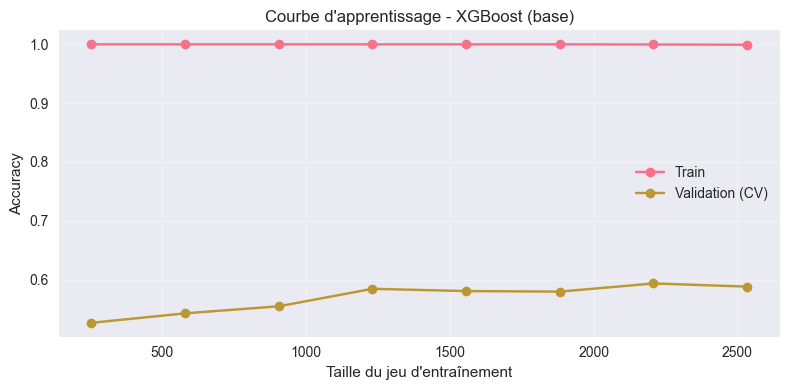

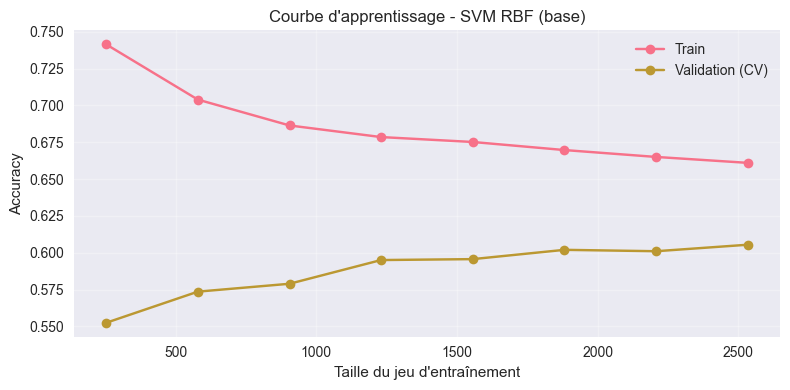

In [38]:
# 9. Courbes d'apprentissage (SVM base, XGBoost base)
models_for_lc = [
    ("XGBoost (base)", xgb_base),
    ("SVM RBF (base)", svm_base)
]

for name, model in models_for_lc:
    # On utilise les données standardisées pour rester cohérent
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X_train_scaled,
        y_train,
        cv=5,
        scoring="accuracy",
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 8),
        shuffle=True,
        random_state=123
    )

    plt.figure(figsize=(8, 4))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), "o-", label="Train")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), "o-", label="Validation (CV)")
    plt.title(f"Courbe d'apprentissage - {name}")
    plt.xlabel("Taille du jeu d'entraînement")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [39]:
# 10. Optimisation SVM (Pipeline + RandomizedSearchCV)

pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(random_state=123))
])

param_grid_svm = {
    "clf__C": np.logspace(-3, 3, 20),
    "clf__gamma": np.logspace(-4, 1, 20),
    "clf__kernel": ["rbf", "linear", "poly"],
    "clf__degree": [2, 3, 4],
    "clf__class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

random_search_svm = RandomizedSearchCV(
    pipe_svm,
    param_distributions=param_grid_svm,
    n_iter=20,
    scoring="f1_weighted",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=123,
    return_train_score=True
)

In [40]:
print(" Optimisation SVM en cours...")
random_search_svm.fit(X_train, y_train)  # données brutes, le scaler est dans le pipeline
print(" Optimisation SVM terminée")

print("Meilleurs paramètres SVM :")
for p, v in random_search_svm.best_params_.items():
    print(f"  {p}: {v}")
print(f"Meilleur score CV SVM (f1_weighted) : {random_search_svm.best_score_:.4f}")

best_svm = random_search_svm.best_estimator_


 Optimisation SVM en cours...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
 Optimisation SVM terminée
Meilleurs paramètres SVM :
  clf__kernel: rbf
  clf__gamma: 0.4832930238571752
  clf__degree: 4
  clf__class_weight: balanced
  clf__C: 0.6951927961775606
Meilleur score CV SVM (f1_weighted) : 0.5783


In [41]:
y_pred_svm = best_svm.predict(X_test)
print("\n Rapport de classification — SVM optimisé (test) :")
print(classification_report(y_test, y_pred_svm, zero_division=0))



 Rapport de classification — SVM optimisé (test) :
              precision    recall  f1-score   support

           0       0.62      0.69      0.65       270
           1       0.59      0.49      0.53       358
           2       0.52      0.63      0.57       165

    accuracy                           0.59       793
   macro avg       0.58      0.60      0.59       793
weighted avg       0.59      0.59      0.58       793



F1-Score SVM optimisé (test) : 0.5822


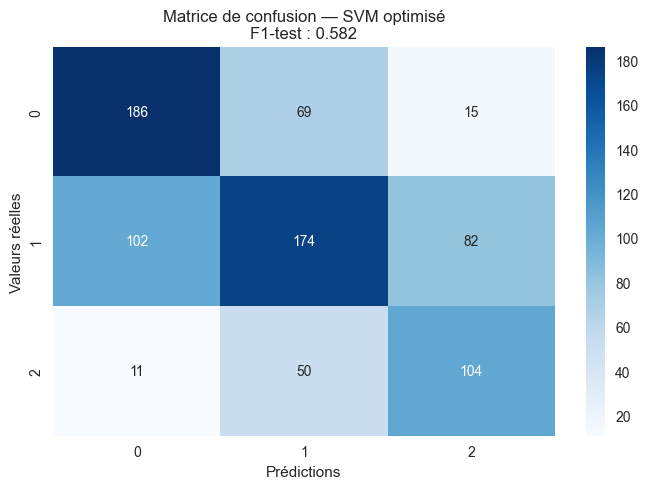

In [42]:
f1_svm_optimized = f1_score(y_test, y_pred_svm, average="weighted")
print(f"F1-Score SVM optimisé (test) : {f1_svm_optimized:.4f}")

cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(7, 5))
sns.heatmap(
    cm_svm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test)
)
plt.title(f"Matrice de confusion — SVM optimisé\nF1-test : {f1_svm_optimized:.3f}")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.tight_layout()
plt.show()


In [43]:
# 11. Optimisation XGBoost

param_grid_xgb = {
    "n_estimators": [100, 200, 400],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "min_child_weight": [1, 3, 5]
}

xgb_for_search = XGBClassifier(
    random_state=123,
    use_label_encoder=False,
    eval_metric="mlogloss",
    n_jobs=-1
)

random_search_xgb = RandomizedSearchCV(
    xgb_for_search,
    param_distributions=param_grid_xgb,
    n_iter=40,
    scoring="f1_weighted",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=123,
    return_train_score=True
)

In [44]:
print(" Optimisation XGBoost en cours...")
random_search_xgb.fit(X_train_scaled, y_train)  # XGBoost entraîné sur données standardisées
print(" Optimisation XGBoost terminée")

print("Meilleurs paramètres XGBoost :")
for p, v in random_search_xgb.best_params_.items():
    print(f"  {p}: {v}")
print(f"Meilleur score CV XGBoost (f1_weighted) : {random_search_xgb.best_score_:.4f}")

best_xgb = random_search_xgb.best_estimator_



 Optimisation XGBoost en cours...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
 Optimisation XGBoost terminée
Meilleurs paramètres XGBoost :
  subsample: 1.0
  n_estimators: 200
  min_child_weight: 3
  max_depth: 5
  learning_rate: 0.1
  colsample_bytree: 0.7
Meilleur score CV XGBoost (f1_weighted) : 0.6083


In [45]:
y_pred_xgb = best_xgb.predict(X_test_scaled)
f1_xgb_optimized = f1_score(y_test, y_pred_xgb, average="weighted")
print("\n Rapport de classification — XGBoost optimisé (test) :")
print(classification_report(y_test, y_pred_xgb, zero_division=0))
print(f"F1-Score XGBoost optimisé (test) : {f1_xgb_optimized:.4f}")



 Rapport de classification — XGBoost optimisé (test) :
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       270
           1       0.58      0.65      0.61       358
           2       0.60      0.45      0.51       165

    accuracy                           0.61       793
   macro avg       0.61      0.58      0.59       793
weighted avg       0.61      0.61      0.61       793

F1-Score XGBoost optimisé (test) : 0.6052


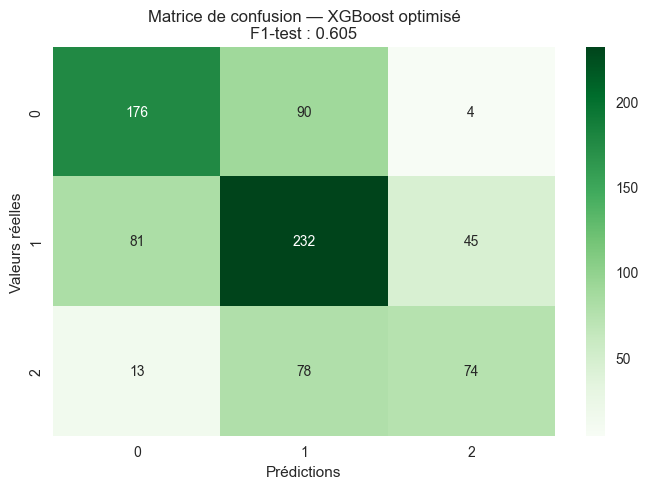

In [46]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(7, 5))
sns.heatmap(
    cm_xgb,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test)
)
plt.title(f"Matrice de confusion — XGBoost optimisé\nF1-test : {f1_xgb_optimized:.3f}")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.tight_layout()
plt.show()

In [47]:
# 12. Comparaison finale SVM optimisé vs XGBoost optimisé

final_models = {
    "SVM Optimisé": best_svm,      # Pipeline avec scaler interne
    "XGBoost Optimisé": best_xgb   # entraîné sur X_train_scaled
}

final_results = []

In [48]:
for name, model in final_models.items():
    if name == "SVM Optimisé":
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    else:
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

    final_results.append({
        "Model": name,
        "Train_Accuracy": accuracy_score(y_train, y_train_pred),
        "Test_Accuracy": accuracy_score(y_test, y_test_pred),
        "F1-Score": f1_score(y_test, y_test_pred, average="weighted", zero_division=0),
        "Precision": precision_score(y_test, y_test_pred, average="weighted", zero_division=0),
        "Recall": recall_score(y_test, y_test_pred, average="weighted", zero_division=0),
    })

final_df = pd.DataFrame(final_results)
display(final_df)


,Model,Train_Accuracy,Test_Accuracy,F1-Score,Precision,Recall
0,SVM Optimisé,0.818182,0.585120,0.582174,0.587558,0.585120
1,XGBoost Optimisé,0.905934,0.607818,0.605217,0.608964,0.607818


In [49]:
best_idx = final_df["F1-Score"].idxmax()
best_model_name = final_df.loc[best_idx, "Model"]
best_accuracy = final_df.loc[best_idx, "Test_Accuracy"]
best_model = final_models[best_model_name]

print(f"\n Meilleur modèle final : {best_model_name}")
print(f"   F1-Score test : {final_df.loc[best_idx, 'F1-Score']:.4f}")
print(f"   Accuracy test : {best_accuracy:.4f}")

if best_model_name == "SVM Optimisé":
    best_params = random_search_svm.best_params_
else:
    best_params = random_search_xgb.best_params_

print("Paramètres associés au meilleur modèle :")
for p, v in best_params.items():
    print(f"  {p}: {v}")


 Meilleur modèle final : XGBoost Optimisé
   F1-Score test : 0.6052
   Accuracy test : 0.6078
Paramètres associés au meilleur modèle :
  subsample: 1.0
  n_estimators: 200
  min_child_weight: 3
  max_depth: 5
  learning_rate: 0.1
  colsample_bytree: 0.7


In [50]:
# 13. Sauvegarde du meilleur modèle

model_data = {
    "model": best_model,
    "feature_names": X.columns.tolist(),
    "accuracy": best_accuracy,
    "best_params": best_params
}

if best_model_name == "XGBoost Optimisé":
    model_data["scaler"] = scaler
else:
    model_data["scaler"] = None

joblib.dump(model_data, "juice_model.pkl")
print("\n💾 Modèle sauvegardé dans 'juice_model.pkl'")



💾 Modèle sauvegardé dans 'juice_model.pkl'
